# “能听会说”好伙伴

硬件准备：麦克风、小音箱

注意事项：
- 文件夹目录中"start.wav"为录音提示语，"audio.wav"为录音时生成的文件。
- 请逐步运行单元格中的代码，即可查看具体效果。
- 如果使用USB小音箱，请务必在电源口接上2A的电源。
- 请确认硬件处于上网状态，否则无法使用百度API相关功能。
    
本范例中百度AI部分内容请参考其官方文档。https://ai.baidu.com/docs#/ASR-Online-Python-SDK/f71dfc54

### 准备工作1：导入基本库

In [2]:
import pyaudio
import wave
import os
import numpy as np
import matplotlib.pyplot as plt
from aip import AipSpeech


### 准备工作2：设置认证信息和参数

注：这里用的是测试账号，有访问次数的限制，如果测试失败，请使用自己的账号信息。

In [24]:
""" 你的 APPID AK SK """
APP_ID = "19612357"
API_KEY = "om90mVUHZfck1sviVg1vuGVW"
SECRET_KEY = "5qy7wvLCRRGGqk22roDkmjBNrfyEcTe1"
""" 这里是参数设置，请不要改动 """
wavdict = {'CHUNK':1024,'CHANNELS':1,'RATE':16000,'RECORD_SECONDS':3}
client = AipSpeech(APP_ID, API_KEY, SECRET_KEY)

录音参数介绍：
- CHUNK：指定每个缓冲区的帧数。
- FORMAT：采样大小和格式。我们这里是pyaudio.paInt16，即16位int型。
- CHANNELS：声道数，这里我们设定的是单声道。
- RATE：采样频率，录音设备在一秒钟内对声音信号的采样次数，采样频率越高声音的还原就越真实越自然。这里是16000。这里是为了匹配后期语音识别的要求设置的。常用的有8kHz, 16kHz, 32kHz, 48kHz, 11.025kHz, 22.05kHz, 44.1kHz.
- RECORD_SECONDS:录音秒数

### 体验:声音的秘密

e:\application\python\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


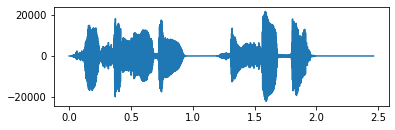

In [7]:
def wavread(path):
    wavfile =  wave.open(path,"rb")
    params = wavfile.getparams()
    framesra,frameswav= params[2],params[3]
    datawav = wavfile.readframes(frameswav)
    wavfile.close()
    datause = np.fromstring(datawav,dtype = np.short)
    datause.shape = -1,2
    datause = datause.T
    time = np.arange(0, frameswav) * (1.0/framesra)
    return datause,time

def main():
    path = r'start.wav'
    wavdata,wavtime = wavread(path)
    plt.subplot(211)
    plt.plot(wavtime, wavdata[1])
    plt.show()
    
main()

### 核心函数getwav:录音

rec函数的作用是录音处理。

In [3]:
def getwav(filename,wavdict):
    CHUNK = int(wavdict['CHUNK'])
    FORMAT = pyaudio.paInt16
    CHANNELS = int(wavdict['CHANNELS'])
    RATE = int(wavdict['RATE'])
    RECORD_SECONDS = int(wavdict['RECORD_SECONDS'])

    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    print("开始录音,请说话...")
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("录音结束!")
    stream.stop_stream()
    stream.close()
    p.terminate()
    wf = wave.open(filename, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    return filename
#尝试运行
#wavdict = {'CHUNK':1024,'CHANNELS':1,'RATE':16000,'RECORD_SECONDS':3}
#getwav('test.wav',wavdict)

### 核心过程语音转文字:基于百度API，将录音转化为文字


In [33]:
with open('audio.wav', 'rb') as f:
    file_context = f.read()
print("正在识别语音...")
res = client.asr(file_context, 'wav', 16000, {'dev_pid': 1537,})
if (res["err_msg"]=="success."):
    print(res.get("result")[0])
else:
    print("错误，没有识别出任何内容！")

正在识别语音...



### 核心过程文字转语音:基于百度API，将文字合成为语音

利用百度AI平台提供的接口，我们可以上传文本信息，得到返回的音频文件。运行这段代码后，返回的音频文件将存放在"audio.wav"中。

In [25]:
from aip import AipSpeech
client = AipSpeech(APP_ID, API_KEY, SECRET_KEY)
txt="我是能听会说的机器人！"
result = client.synthesis(txt, 'zh', 1, {'vol': 5,})
if not isinstance(result, dict):
    with open('audio.wav', 'wb') as f:
        f.write(result)
#windows环境下直接播放语音
#os.system('audio.wav')

### pytts3库使用案例
利用py将文字转为语音，并且朗读出来。

In [1]:
import pyttsx3
engine = pyttsx3.init()
words='我是能听会说的机器人！'
engine.say(words)
engine.runAndWait()

# 实践活动1：吟诗作对机器人

实践内容：制作一个能够“吟诗作对”的机器人，它能够与我们进行对话，听到诗词的上半部分就会自动对出下半部分。这个机器人可以被用在语文课堂上，也可以用于日常生活之中，供我们练习古诗词。

### 实践步骤1：定义词库

In [2]:
#添加诗词库，用户读前一句（奇数），机器对出下一句（偶数）
shici = ['床前明月光', '疑是地上霜', '举头望明月','低头思故乡']
shici.extend(['大漠沙如雪', '燕山月似钩', '何当金络脑','快走踏清秋'])
#字符串相加，采用+的方式
shici=shici + ['海上生明月', '天涯共此时']
#输出列表
print(shici)

['床前明月光', '疑是地上霜', '举头望明月', '低头思故乡', '大漠沙如雪', '燕山月似钩', '何当金络脑', '快走踏清秋', '海上生明月', '天涯共此时']


### 实践步骤2：核心逻辑

In [ ]:
#播放提示语
os.system('start.wav')
#开始录音
wavdict = {'CHUNK':1024,'CHANNELS':1,'RATE':16000,'RECORD_SECONDS':3}
getwav('input.wav',wavdict)
with open('input.wav', 'rb') as f:
    file_context = f.read()
print("正在识别语音...")
res = client.asr(file_context, 'wav', 16000, {'dev_pid': 1537,})
if (res["err_msg"]=="success."):
    ret=res.get("result")[0])
else:
    ret="错误，没有识别出任何内容！"
print(ret)
for i in range(len(shici)//2):  
    if shici[i*2] in ret:
        back=shici[i*2+1]
        break
    else:
        back="在下才疏学浅，甘拜下风。"
print(back)  
result = client.synthesis(back, 'zh', 1, {'vol': 5,})
if not isinstance(result, dict):
    with open('audio.wav', 'wb') as f:
        f.write(result)
os.system('audio.wav')

### 实践步骤3：功能优化

1.请给“诗词库”（变量shici）增加新的数据，使其可以支持更多的回答。

2.修改变量shici的内容，让这个程序可以在其他的特定场合工作。


### 结果呈现：

完成作品后，尝试与这个机器人“吟诗作对”。
通过遍历字符串的方式，我们可以从词库中找到对应的诗句，我们还可以调用人工智能生成古诗的接口，返回更加有趣新颖的诗句。在案例中，语音的输入输出都是信息的表现方式，我们通过修改其内部算法，完成了人机交互。

# 实践活动2：语音唤醒小助手（选学）

实践内容：在上一小节中，我们尝试制作了一个聊天机器人，现在，我们可以使用语音唤醒技术，将其制作地更加完善。当我们想要唤醒这个小助手时，就说出它的名字，随后与它进行对话。

### 实践步骤1：唤醒机制

参考上文中提到的两种唤醒机制，选择其中一种进行设计。


In [35]:
#getwav函数录制音频
#识别音频内容
#创建一个代表姓名的列表，进行遍历
#如果遍历结果为成功，则请用户提出问题，转入步骤2开始正常对话。

### 实践步骤2：对话功能

参考AIML机器人，将用户的输入语句，修改为本章节中学习到的语音识别，将机器人的输出语句，修改为语音合成。

### 实践步骤3：功能优化

想要完成基本功能，我们可以让小助手录制唤醒后5秒内的录音，并作出应答。生活中的对话时长都是不固定的，我们还可以添加另一个线程，对用户的说话情况进行侦测，如果5秒后出现了长时间的沉默，才中止录音。


### 结果呈现：



完成作品后，与小助手模拟生活中常见的情境：“同学之间打招呼”“超市买东西”进行对话。对于我们学习到的知识，要做到活学活用，结合自己的知识储备，实现1(AIML对话)+1(语音输入与输出)>2(优质作品)的效果。